# BCI Giuseppe Bonomo

In [1]:
#%%
!git clone https://github.com/marco-siino/EEG-ATCNet.git
!pip install mne
!pip install PyWavelets
#Le ulitme versioni non sono compatibili con le librerie usate
#in preprocess_HGD.py, quindi si è optato a utilizzare una versione meno recente
!pip install braindecode==0.3

import os
import sys
import shutil
import time
import pywt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
os.chdir("/Users/giuseppebonomo/Desktop/UNIPA CdLM Ing_Informatica/Tesi/CodiceBCI/EEG-ATCNet")

import models

#from preprocess import get_data
# from keras.utils.vis_utils import plot_model

fatal: destination path 'EEG-ATCNet' already exists and is not an empty directory.


# Organize the dataset.

In [2]:
# Creare la cartella "dataset" e "results" se non esistono già
os.makedirs("dataset", exist_ok=True)

#Crea la sotto-cartella train e test
os.makedirs("dataset/train", exist_ok=True)
os.makedirs("dataset/test", exist_ok=True)

In [3]:
"""import os
import requests
from pathlib import Path
from tqdm import tqdm

# Definizione URL base
train_url = "https://gin.g-node.org/robintibor/high-gamma-dataset/raw/master/data/train"
test_url = "https://gin.g-node.org/robintibor/high-gamma-dataset/raw/master/data/test"

# Creazione cartelle se non esistono
train_dir = Path("dataset/train")
test_dir = Path("dataset/test")
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

def download_file(url, filepath):
    #Scarica un file con una barra di avanzamento
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        total_size = int(response.headers.get("content-length", 0))
        with open(filepath, "wb") as f, tqdm(
            desc=filepath.name, total=total_size, unit="B", unit_scale=True
        ) as bar:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
                bar.update(len(chunk))
    else:
        print(f"Errore nel download di {url}: {response.status_code}")

# Scarico i file di train e test
for i in range(1, 15):
    train_file = train_dir / f"{i}.mat"
    test_file = test_dir / f"{i}.mat"

    download_file(f"{train_url}/{i}.mat", train_file)
    download_file(f"{test_url}/{i}.mat", test_file)

print("Download completato!")
"""

'import os\nimport requests\nfrom pathlib import Path\nfrom tqdm import tqdm\n\n# Definizione URL base\ntrain_url = "https://gin.g-node.org/robintibor/high-gamma-dataset/raw/master/data/train"\ntest_url = "https://gin.g-node.org/robintibor/high-gamma-dataset/raw/master/data/test"\n\n# Creazione cartelle se non esistono\ntrain_dir = Path("dataset/train")\ntest_dir = Path("dataset/test")\ntrain_dir.mkdir(parents=True, exist_ok=True)\ntest_dir.mkdir(parents=True, exist_ok=True)\n\ndef download_file(url, filepath):\n    #Scarica un file con una barra di avanzamento\n    response = requests.get(url, stream=True)\n    if response.status_code == 200:\n        total_size = int(response.headers.get("content-length", 0))\n        with open(filepath, "wb") as f, tqdm(\n            desc=filepath.name, total=total_size, unit="B", unit_scale=True\n        ) as bar:\n            for chunk in response.iter_content(chunk_size=1024):\n                f.write(chunk)\n                bar.update(len(chunk)

In [4]:
"""#Scarico i dati di train e test per High Gamma Dataset
train = "https://gin.g-node.org/robintibor/high-gamma-dataset/src/master/data/train"
test = "https://gin.g-node.org/robintibor/high-gamma-dataset/src/master/data/test"

#Assegno ad ogni dato un id T per train e E per evaluation, aggiungendoli alla cartella s{i}
for i in range(1, 15):
    os.system(f"wget -O dataset/train/{i}.mat {train}/{i}.mat")
    os.system(f"wget -O dataset/test/{i}.mat {test}/{i}.mat")"""

'#Scarico i dati di train e test per High Gamma Dataset\ntrain = "https://gin.g-node.org/robintibor/high-gamma-dataset/src/master/data/train"\ntest = "https://gin.g-node.org/robintibor/high-gamma-dataset/src/master/data/test"\n\n#Assegno ad ogni dato un id T per train e E per evaluation, aggiungendoli alla cartella s{i}\nfor i in range(1, 15):\n    os.system(f"wget -O dataset/train/{i}.mat {train}/{i}.mat")\n    os.system(f"wget -O dataset/test/{i}.mat {test}/{i}.mat")'

In [5]:
"""# Download the dataset.
base_url = "https://bnci-horizon-2020.eu/database/data-sets/001-2014/"
save_path = "dataset/"

for i in range(1, 10):  # Da A01 a A09
    for suffix in ["T", "E"]:  # T per training, E per evaluation
        filename = f"A{i:02d}{suffix}.mat"
        url = base_url + filename
        os.system(f"wget -O {save_path}s{i}/{filename} {url}")"""

'# Download the dataset.\nbase_url = "https://bnci-horizon-2020.eu/database/data-sets/001-2014/"\nsave_path = "dataset/"\n\nfor i in range(1, 10):  # Da A01 a A09\n    for suffix in ["T", "E"]:  # T per training, E per evaluation\n        filename = f"A{i:02d}{suffix}.mat"\n        url = base_url + filename\n        os.system(f"wget -O {save_path}s{i}/{filename} {url}")'

# Functions definitions

In [6]:
#%%
def draw_learning_curves(history, sub):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - subject: ' + str(sub))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - subject: ' + str(sub))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, sub, results_path, classes_labels):
    # Generate confusion matrix plot
    display_labels = classes_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])

# Preprocessing functions definition

## DB4 (Soft -> Threshold 5.5)

In [7]:
def db4_soft(signal, wavelet='db4', level=4, threshold=5.5):
    """
    Applica la RDWT (Discrete Wavelet Transform) al segnale e lo ricostruisce,
    rimuovendo i coefficienti di dettaglio sotto una certa soglia per enfatizzare
    le caratteristiche principali del segnale.

    Args:
    - signal: il segnale da elaborare
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - level: livello della decomposizione (default 4)
    - threshold: soglia per i coefficienti di dettaglio (default 0.5)

    Returns:
    - Il segnale ricostruito dopo la manipolazione della RDWT
    """


    print("Lunghezza originale:", signal.shape[-1])  # Dovrebbe essere 1125
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)
    print("Lunghezza coefficiente di approssimazione:", len(coeffs[0]))

    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='per')
    print("Lunghezza ricostruita:", len(reconstructed_signal))

    # Decomposizione del segnale in coefficienti
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)

    # Modifica i coefficienti di dettaglio
    # Si applica un threshold sui coefficienti di dettaglio per "ridurre" la componente di alta frequenza
    coeffs_thresholded = [coeffs[0]]  # Mantieni il coefficiente di approssimazione
    for i in range(1, len(coeffs)):
        coeffs_thresholded.append(np.where(np.abs(coeffs[i]) < threshold, 0, coeffs[i]))

    # Ricostruzione del segnale dai coefficienti modificati
    reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet, mode='per')

    # Taglia il segnale ricostruito per mantenerne la stessa lunghezza dell'input
    return reconstructed_signal[:len(signal)]


## DB4 (Hard -> Threshold 10.5)

In [8]:
def db4_hard(signal, wavelet='db4', level=4, threshold=10.5):
    """
    Applica la RDWT (Discrete Wavelet Transform) al segnale e lo ricostruisce,
    rimuovendo i coefficienti di dettaglio sotto una certa soglia per enfatizzare
    le caratteristiche principali del segnale.

    Args:
    - signal: il segnale da elaborare
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - level: livello della decomposizione (default 4)
    - threshold: soglia per i coefficienti di dettaglio (default 0.5)

    Returns:
    - Il segnale ricostruito dopo la manipolazione della RDWT
    """

    # Decomposizione del segnale in coefficienti
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)

    # Modifica i coefficienti di dettaglio
    # Si applica un threshold sui coefficienti di dettaglio per "ridurre" la componente di alta frequenza
    coeffs_thresholded = [coeffs[0]]  # Mantieni il coefficiente di approssimazione
    for i in range(1, len(coeffs)):
        coeffs_thresholded.append(np.where(np.abs(coeffs[i]) < threshold, 0, coeffs[i]))

    # Ricostruzione del segnale dai coefficienti modificati
    reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet, mode='per')

    # Taglia il segnale ricostruito per mantenerne la stessa lunghezza dell'input
    return reconstructed_signal[:len(signal)]


## RDWT

In [9]:
import numpy as np
import scipy.signal as signal
import pywt

def rational_dilated_wavelet_transform(sig, wavelet='db4', levels=4, dilation_factors=None, threshold=5.5):
    """
    Applica la Rational Dilated Wavelet Transform (RDWT) a un segnale EEG multidimensionale.

    Args:
    - sig: array numpy di forma (eventi, 1, canali, campioni)
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - levels: numero di livelli di decomposizione (default 4)
    - dilation_factors: lista di fattori di dilatazione razionale (default: [3/2, 5/3, 7/4, ...])
    - threshold: soglia per i coefficienti di dettaglio (default 5.5)

    Returns:
    - Segnale ricostruito con la RDWT (stessa dimensione dell'input)
    """
    eventi, _, canali, campioni = sig.shape
    print("Lunghezza originale del segnale:", sig.shape)

    if dilation_factors is None:
        dilation_factors = [3/2, 5/3, 7/4, 9/5]

    coeffs_approx = sig.copy()  # Inizializza con il segnale originale
    detail_coeffs = []

    for i in range(levels):
        factor = dilation_factors[i]
        wavelet_filter = pywt.Wavelet(wavelet)
        lo_d, hi_d = wavelet_filter.dec_lo, wavelet_filter.dec_hi

        # Ridimensionamento dei filtri
        lo_d = signal.resample(lo_d, int(len(lo_d) * factor))
        hi_d = signal.resample(hi_d, int(len(hi_d) * factor))

        print(f"Livello {i+1}: coeffs_approx shape {coeffs_approx.shape}, lo_d shape {lo_d.shape}, hi_d shape {hi_d.shape}")

        approx = np.zeros_like(coeffs_approx)
        detail = np.zeros_like(coeffs_approx)

        # Applica la convoluzione per ogni canale EEG
        for e in range(eventi):
            for c in range(canali):
                approx[e, 0, c, :] = np.convolve(coeffs_approx[e, 0, c, :], lo_d, mode='same')
                detail[e, 0, c, :] = np.convolve(coeffs_approx[e, 0, c, :], hi_d, mode='same')

                # Soglia sui coefficienti di dettaglio
                detail[e, 0, c, np.abs(detail[e, 0, c, :]) < threshold] = 0

        detail_coeffs.append(detail)
        coeffs_approx = approx  # Passa l'approssimazione al livello successivo

    # Ricostruzione del segnale
    reconstructed = coeffs_approx.copy()
    for i in range(levels-1, -1, -1):
        reconstructed += detail_coeffs[i]

    print("Lunghezza del segnale ricostruito:", reconstructed.shape)
    return reconstructed

In [10]:
def apply_preprocessing (signals_data, preprocessing):
  if preprocessing=="none":
    return signals_data
  elif preprocessing=="db4_soft":
    return db4_soft(signals_data)
  elif preprocessing=="db4_hard":
    return db4_hard(signals_data)
  elif preprocessing=="rdwt":
    return rational_dilated_wavelet_transform(signals_data)


# Model training function

In [11]:
import h5py

# Apre il file .mat in modalità lettura
with h5py.File("dataset/train/1.mat", 'r') as f:
    # Stampa le chiavi principali nel file .mat
    print("Chiavi principali del file .mat:", list(f.keys()))
    
    # Esamina i dati per una chiave specifica ('ch1')
    if 'ch1' in f:
        X_data = f['ch1']
        print("Shape di ch1:", X_data.shape)
        print("Dati di ch1 (primo trial):", X_data[0])

    


Chiavi principali del file .mat: ['ch1', 'ch10', 'ch100', 'ch101', 'ch102', 'ch103', 'ch104', 'ch105', 'ch106', 'ch107', 'ch108', 'ch109', 'ch11', 'ch110', 'ch111', 'ch112', 'ch113', 'ch114', 'ch115', 'ch116', 'ch117', 'ch118', 'ch119', 'ch12', 'ch120', 'ch121', 'ch122', 'ch123', 'ch124', 'ch125', 'ch126', 'ch127', 'ch128', 'ch129', 'ch13', 'ch130', 'ch131', 'ch132', 'ch133', 'ch14', 'ch15', 'ch16', 'ch17', 'ch18', 'ch19', 'ch2', 'ch20', 'ch21', 'ch22', 'ch23', 'ch24', 'ch25', 'ch26', 'ch27', 'ch28', 'ch29', 'ch3', 'ch30', 'ch31', 'ch32', 'ch33', 'ch34', 'ch35', 'ch36', 'ch37', 'ch38', 'ch39', 'ch4', 'ch40', 'ch41', 'ch42', 'ch43', 'ch44', 'ch45', 'ch46', 'ch47', 'ch48', 'ch49', 'ch5', 'ch50', 'ch51', 'ch52', 'ch53', 'ch54', 'ch55', 'ch56', 'ch57', 'ch58', 'ch59', 'ch6', 'ch60', 'ch61', 'ch62', 'ch63', 'ch64', 'ch65', 'ch66', 'ch67', 'ch68', 'ch69', 'ch7', 'ch70', 'ch71', 'ch72', 'ch73', 'ch74', 'ch75', 'ch76', 'ch77', 'ch78', 'ch79', 'ch8', 'ch80', 'ch81', 'ch82', 'ch83', 'ch84', 'ch8

In [12]:
#%% Training
from preprocess import get_data

def train(dataset_conf, train_conf, results_path):

    # remove the 'result' folder before training
    if os.path.exists(results_path):
        # Remove the folder and its contents
        shutil.rmtree(results_path)
        os.makedirs(results_path)

    # Get the current 'IN' time to calculate the overall training time
    in_exp = time.time()
    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models.txt", "w")
    # Create a file to store performance during training
    log_write = open(results_path + "/log.txt", "w")

    # Get dataset parameters
    dataset = dataset_conf.get('name')
    print("Dataset: ", dataset)
    n_sub = dataset_conf.get('n_sub')
    print("Number of subjects: ", n_sub)
    data_path = dataset_conf.get('data_path')
    print("Data path: ", data_path)
    isStandard = dataset_conf.get('isStandard')
    print("Standardization: ", isStandard)
    LOSO = dataset_conf.get('LOSO')
    print("Leave-one-subject-out: ", LOSO)
    # Get training hyperparamters
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    signal_preprocessing = dataset_conf.get('signal_preprocessing')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves') # Plot Learning Curves?
    n_train = train_conf.get('n_train')
    model_name = train_conf.get('model')
    from_logits = train_conf.get('from_logits')

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.

        print('\nTraining on subject ', sub+1)
        log_write.write( '\nTraining on subject '+ str(sub+1) +'\n')
        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0
        bestTrainingHistory = []

        # Get training and validation data
        print("Sto per chiamare get_data")
        X_train, _, y_train_onehot, _, _, _ = get_data(
            data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        print("Dopo get_data")
        print("X_train shape is:"+str(X_train.shape))
        # Divide the training data into training and validation
        X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)


        print("\n\nBefore preprocessing X_train shape is:"+str(X_train.shape))
        print("Before preprocessing X_val shape is:"+str(X_val.shape))

        X_train = apply_preprocessing(X_train, preprocessing=signal_preprocessing)
        X_val = apply_preprocessing(X_val, preprocessing=signal_preprocessing)
        print("\n\nAfter preprocessing X_train shape is:"+str(X_train.shape))
        print("After preprocessing X_val shape is:"+str(X_val.shape))


        # Iteration over multiple runs
        for train in range(n_train): # How many repetitions of training for subject i.
            # Set the random seed for TensorFlow and NumPy random number generator.
            # The purpose of setting a seed is to ensure reproducibility in random operations.
            tf.random.set_seed(train+1)
            np.random.seed(train+1)

            # Get the current 'IN' time to calculate the 'run' training time
            in_run = time.time()

            # Create folders and files to save trained models for all runs
            filepath = results_path + '/saved models/run-{}'.format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)
            filepath = filepath + '/subject-{}.weights.h5'.format(sub+1)

            # Create the model
            model = getModel(model_name, dataset_conf, from_logits)
            # Compile and train the model
            model.compile(loss=CategoricalCrossentropy(from_logits=from_logits), optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

            # model.summary()
            # plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)

            callbacks = [
                ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                                save_best_only=True, save_weights_only=True, mode='min'),
                ReduceLROnPlateau(monitor="val_loss", factor=0.90, patience=20, verbose=0, min_lr=0.0001),
                # EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=patience)
            ]
            history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot),
                                epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)

            # Evaluate the performance of the trained model based on the validation data
            # Here we load the Trained weights from the file saved in the hard
            # disk, which should be the same as the weights of the current model.
            model.load_weights(filepath)
            y_pred = model.predict(X_val)

            if from_logits:
                y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            else:
                y_pred = y_pred.argmax(axis=-1)

            labels = y_val_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)

            # Get the current 'OUT' time to calculate the 'run' training time
            out_run = time.time()
            # Print & write performance measures for each run
            info = 'Subject: {}   seed {}   time: {:.1f} m   '.format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + 'valid_acc: {:.4f}   valid_loss: {:.3f}'.format(acc[sub, train], min(history.history['val_loss']))
            print(info)
            log_write.write(info +'\n')
            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history

        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        filepath = '/saved models/run-{}/subject-{}.h5'.format(best_run+1, sub+1)+'\n'
        best_models.write(filepath)

        # Plot Learning curves
        if (LearnCurves == True):
            print('Plot Learning Curves ....... ')
            draw_learning_curves(bestTrainingHistory, sub+1)

    # Get the current 'OUT' time to calculate the overall training time
    out_exp = time.time()

    # Print & write the validation performance using all seeds
    head1 = head2 = '         '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n---------------------------------\nValidation performance (acc %):'
    info = info + '\n---------------------------------\n' + head1 +'\n'+ head2
    for run in range(n_train):
        info = info + '\nSeed {}:  '.format(run+1)
        for sub in range(n_sub):
            info = info + '{:.2f}   '.format(acc[sub, run]*100)
        info = info + '  {:.2f}   '.format(np.average(acc[:, run])*100)
    info = info + '\n---------------------------------\nAverage acc - all seeds: '
    info = info + '{:.2f} %\n\nTrain Time  - all seeds: {:.1f}'.format(np.average(acc)*100, (out_exp-in_exp)/(60))
    info = info + ' min\n---------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Close open files
    best_models.close()
    log_write.close()

# Evaluation function

In [13]:
#%% Evaluation
def test(model, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results
    log_write = open(results_path + "/log.txt", "a")

    # Get dataset paramters
    dataset = dataset_conf.get('name')
    signal_preprocessing = dataset_conf.get('signal_preprocessing')
    n_classes = dataset_conf.get('n_classes')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')
    #Ripetuto
    #signal_preprocessing = dataset_conf.get('signal_preprocessing')

    # Test the performance based on several runs (seeds)
    runs = os.listdir(results_path+"/saved models")
    # Initialize variables
    acc = np.zeros((n_sub, len(runs)))
    kappa = np.zeros((n_sub, len(runs)))
    cf_matrix = np.zeros([n_sub, len(runs), n_classes, n_classes])

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        X_test = apply_preprocessing(X_test, preprocessing=signal_preprocessing)

        # Iteration over runs (seeds)
        for seed in range(len(runs)):
            # Load the model of the seed.
            model.load_weights('{}/saved models/{}/subject-{}.h5'.format(results_path, runs[seed], sub+1))

            inference_time = time.time()
            # Predict MI task
            y_pred = model.predict(X_test).argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, y_pred)
            kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, y_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)

    # Print & write the average performance measures for all subjects
    head1 = head2 = '                  '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(len(runs)):
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub):
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Draw a performance bar chart for all subjects
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file
    log_write.close()

# Model selection and setup

In [14]:
#%%
def getModel(model_name, dataset_conf, from_logits = False):

    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'RockNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.RockNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 64,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.ATCNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

# Run the simulation

## Define the run function.

In [15]:
#%%
def run(signal_preprocessing):
    # Define dataset parameters
    #dataset = 'BCI2a' # Options: 'BCI2a','HGD', 'CS2R'
    dataset = 'HGD'

    if dataset == 'BCI2a':
        in_samples = 1125
        n_channels = 22
        n_sub = 9
        n_classes = 4
        classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
        data_path = 'dataset/' #os.path.expanduser('~') + '/BCI Competition IV/BCI Competition IV-2a/BCI Competition IV 2a mat/'
    elif dataset == 'HGD':
        #print("Dataset scelto:",dataset)
        in_samples = 1125
        n_channels = 44
        n_sub = 14
        n_classes = 4
        classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']
        data_path = 'dataset/' #os.path.expanduser('~') + '/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/'
        #print("Data path:",data_path)
    elif dataset == 'CS2R':
        in_samples = 1125
        # in_samples = 576
        n_channels = 32
        n_sub = 18
        n_classes = 3
        # classes_labels = ['Fingers', 'Wrist','Elbow','Rest']
        classes_labels = ['Fingers', 'Wrist','Elbow']
        # classes_labels = ['Fingers', 'Elbow']
        data_path = os.path.expanduser('~') + '/CS2R MI EEG dataset/all/EDF - Cleaned - phase one (remove extra runs)/two sessions/'
    else:
        raise Exception("'{}' dataset is not supported yet!".format(dataset))

    # Create a folder to store the results of the experiment
    results_path = os.getcwd() + "/results"
    if not  os.path.exists(results_path):
      os.makedirs(results_path)   # Create a new directory if it does not exist

    # Set dataset paramters
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                    'data_path': data_path, 'isStandard': True, 'LOSO': False,
                     'signal_preprocessing':signal_preprocessing}

    # Set training hyperparamters
    train_conf = { 'batch_size': 64, 'epochs': 500, 'patience': 100, 'lr': 0.001,'n_train': 1,
                  'LearnCurves': True, 'from_logits': False, 'model':'RockNet'}

    # Train the model
    print("Training the model...")
    train(dataset_conf, train_conf, results_path)
    print("Training completed!")

    # Evaluate the model based on the weights saved in the '/results' folder
    model = getModel(train_conf.get('model'), dataset_conf)
    test(model, dataset_conf, results_path)


## No preprocessing on EEG.

Training the model...
Dataset:  HGD
Number of subjects:  14
Data path:  dataset/
Standardization:  True
Leave-one-subject-out:  False

Training on subject  1
Sto per chiamare get_data
Path dati:  dataset/
Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
Clean ivan samples:  [-250, 2500]
320 events found on stim channel STI 014
Event IDs: [2 4 6 8]
DEBUG - Event codes presenti: [2 4 6 8]
DEBUG - Dimensioni del nuovo dataset: (128, 1225545)
Annotazioni presenti nel dataset: <Annotations | 320 segments: Feet (80), Left Hand (80), Rest (80), Right ...>
cnt: <class 'mne.io.array.array.RawArray'>, shape: (128, 1225545)
marker_def: OrderedDict([('Right Hand', [2]), ('Left Hand', [4]), ('Rest', [6]), ('Feet', [8])])
clean_ival: [-500, 5000]
Sampling frequency: 500.0 Hz
Primo evento: 10.00 s, Ultimo evento: 2438.86 s
CNT-INFO: <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC

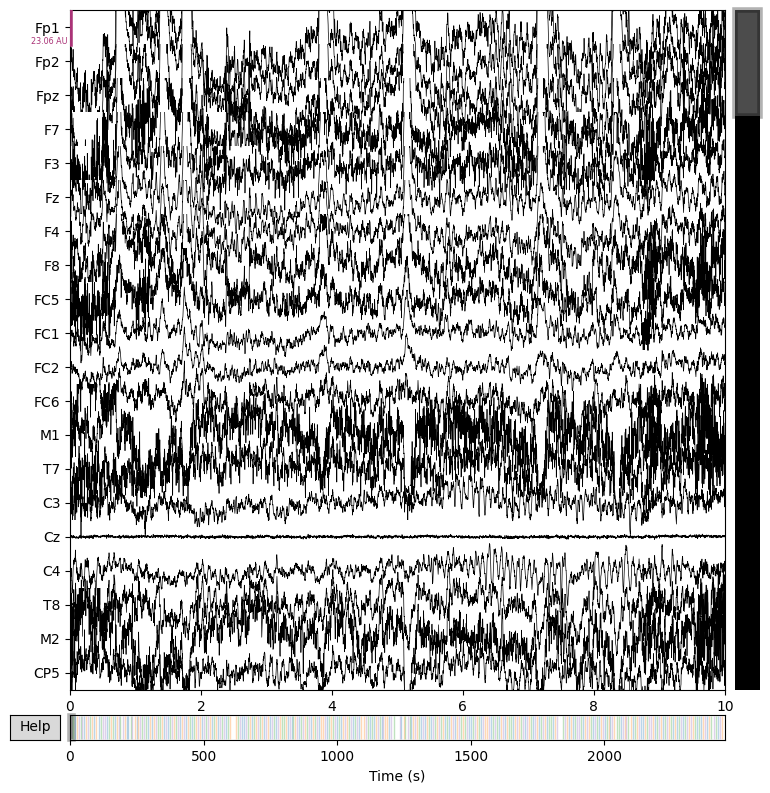

Eventi validi dopo filtro: 320


Ignore trial with marker code 6, would start at sample -240
Ignore trial with marker code 8, would start at sample -233
Ignore trial with marker code 4, would start at sample -226
Ignore trial with marker code 2, would start at sample -219
Ignore trial with marker code 6, would start at sample -211
Ignore trial with marker code 2, would start at sample -204
Ignore trial with marker code 8, would start at sample -197
Ignore trial with marker code 4, would start at sample -189
Ignore trial with marker code 2, would start at sample -182
Ignore trial with marker code 6, would start at sample -175
Ignore trial with marker code 4, would start at sample -167
Ignore trial with marker code 8, would start at sample -159
Ignore trial with marker code 4, would start at sample -151
Ignore trial with marker code 8, would start at sample -144
Ignore trial with marker code 6, would start at sample -136
Ignore trial with marker code 2, would start at sample -129
Ignore trial with marker code 2, would s

DEBUG FUNZIONE - Data shape: (128, 1225545)
DEBUG: Eventi estratti: [[10.002, 0, [6]], [17.452, 0, [8]], [24.472, 0, [4]], [31.882, 0, [2]], [39.462, 0, [6]], [46.552, 0, [2]], [53.802, 0, [8]], [61.102, 0, [4]], [68.212, 0, [2]], [75.842, 0, [6]], [83.162, 0, [4]], [91.142, 0, [8]], [99.072, 0, [4]], [106.732, 0, [8]], [114.382, 0, [6]], [121.892, 0, [2]], [129.592, 0, [2]], [136.652, 0, [8]], [144.382, 0, [6]], [152.112, 0, [4]], [159.282, 0, [6]], [167.072, 0, [8]], [174.112, 0, [4]], [181.812, 0, [2]], [188.922, 0, [6]], [196.502, 0, [2]], [204.032, 0, [4]], [211.742, 0, [8]], [218.912, 0, [8]], [226.662, 0, [6]], [233.662, 0, [2]], [241.422, 0, [4]], [249.032, 0, [8]], [256.122, 0, [4]], [263.342, 0, [2]], [270.412, 0, [6]], [277.652, 0, [2]], [285.322, 0, [6]], [292.862, 0, [8]], [299.942, 0, [4]], [307.042, 0, [8]], [314.872, 0, [4]], [322.072, 0, [2]], [329.962, 0, [6]], [337.662, 0, [6]], [345.522, 0, [4]], [353.462, 0, [8]], [360.632, 0, [2]], [368.332, 0, [8]], [375.452, 0, 

Different labels within one trial: [[1 1 0 1]
 [1 1 1 1]],setting single trial label to  [1. 0. 0. 0.]
Different labels within one trial: [[1 1 0 0]
 [1 1 0 1]
 [1 1 1 1]],setting single trial label to  [1. 0. 0. 0.]
Different labels within one trial: [[0 1 0 0]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 1]],setting single trial label to  [0. 1. 0. 0.]


Numero di segmenti estratti: ['X', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'y']
DEBUG: set_for_cleaning type: <class 'braindecode.datautil.signal_target.SignalAndTarget'>
DEBUG: set_for_cleaning.X dir : ['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__ge

This is not causal, uses future data....


RuntimeError: sfreq cannot be set directly. Please use method inst.resample() instead.

In [16]:
run("none")

## DB4 (Soft) Preprocessing.

In [ ]:
run("db4_soft")

## DB4 (Hard) Preprocessing.

In [ ]:
run("db4_hard")

## RDWT

In [ ]:
run("rdwt")